In [50]:
import numpy as np
import scipy.integrate
import copy
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
import winsound as ws
import cProfile

class ADM1_instance:
    def __init__(self, T_ad = 298.15, V_liq = 3400, V_gas = 300, p_atm = 1.013, q_ad = 0):

        ## unit for each parameter is commented after it is declared (inline)
        ## if the suggested value for the parameter is different -
        ## The original default value from the original ADM1 report by Batstone et al (2002), is commented after each unit (inline)
        
        # reading influent and initial condition data from csv files
        influent_state_temp = pd.read_csv("digester_influent.csv") #this drastically decreases processing time
        self.influent_state  = influent_state_temp.to_dict()
        
        self.initial_state = pd.read_csv("digester_initial.csv")
        
        # Stoichiometric parameter
        Stoichiometric_parameters_temp = pd.read_csv("Definitions.csv", skiprows = [0,1,2], index_col = 0, usecols = [0,1], float_precision='round_trip') #read all stoichiometric parameters as acuratly as available
        self.Stoichiometric_parameters = Stoichiometric_parameters_temp.value.to_dict() #this drastically decreases processing time
        
        self.pH = 7.4655377 # initial pH
        self.T_op =  308.15 #k
        # Physical parameter values used in BSM2 from the Rosen et al (2006) BSM2 report
        
        #testing volume for experiment
        self.T_ad =  T_ad   #K
        self.V_liq = V_liq  #m^3
        self.V_gas = V_gas  #m^3
        self.p_atm = p_atm  #bar
        self.q_ad =  q_ad   #m^3.d^-1 initial flow rate (can be modified during the simulation by the control algorithm)
        
        self.V_ad = self.V_liq + self.V_gas #m^-3
        
        ##constant definition from the Rosen et al (2006) BSM2 report
        self.R =  0.083145 #bar.M^-1.K^-1
        self.T_base =  298.15 #K
        
        # Physico-chemical parameter values from the Rosen et al (2006) BSM2 report
        self.K_a_va =  10 ** -4.86 #M  ADM1 value = 1.38 * 10 ^ -5
        self.K_a_bu =  10 ** -4.82 #M #1.5 * 10 ^ -5
        self.K_a_pro =  10 ** -4.88 #M #1.32 * 10 ^ -5
        self.K_a_ac =  10 ** -4.76 #M #1.74 * 10 ^ -5
        self.K_a_H2S = 10 ** -7.04 #M from pubchem
        self.k_A_B_va =  10 ** 10 #M^-1 * d^-1
        self.k_A_B_bu =  10 ** 10 #M^-1 * d^-1
        self.k_A_B_pro =  10 ** 10 #M^-1 * d^-1
        self.k_A_B_ac =  10 ** 10 #M^-1 * d^-1
        self.k_A_B_co2 =  10 ** 10 #M^-1 * d^-1
        self.k_A_B_IN =  10 ** 10 #M^-1 * d^-1
        self.k_A_B_H2S = 10 ** 10 #M^-1 * d^-1 assumed based on above figures
        self.k_p = 5 * 10 ** 4 #m^3.d^-1.bar^-1 #only for BSM2 AD conditions, recalibrate for other AD cases #gas outlet friction
        self.k_L_a =  200.0 #d^-1
       
        self.S_nh4_ion = 0.0041 #kmole N.m^-3 the initial value is from Rosen et al (2006) BSM2 report and it is calculated further down and does not need to be initiated
        self.S_co2 = 0.14 #kmole C.m^-3 the initial value is from Rosen et al (2006) BSM2 report and it is calculated further down and does not need to be initiated
        
        self.K_w =  10 ** -14.0 * np.exp((55900 / (100 * self.R)) * (1 / self.T_base - 1 / self.T_ad)) #M #2.08 * 10 ^ -14
        self.K_a_co2 =  10 ** -6.35 * np.exp((7646 / (100 * self.R)) * (1 / self.T_base - 1 / self.T_ad)) #M #4.94 * 10 ^ -7
        self.K_a_IN =  10 ** -9.25 * np.exp((51965 / (100 * self.R)) * (1 / self.T_base - 1 / self.T_ad)) #M #1.11 * 10 ^ -9
        self.p_gas_h2o =  0.0313 * np.exp(5290 * (1 / self.T_base - 1 / self.T_ad)) #bar #0.0557
        self.K_H_co2 =  0.035 * np.exp((-19410 / (100 * self.R))* (1 / self.T_base - 1 / self.T_ad)) #Mliq.bar^-1 #0.0271
        self.K_H_ch4 =  0.0014 * np.exp((-14240 / (100 * self.R)) * (1 / self.T_base - 1 / self.T_ad)) #Mliq.bar^-1 #0.00116
        self.K_H_h2 =  7.8 * 10 ** -4 * np.exp(-4180 / (100 * self.R) * (1 / self.T_base - 1 / self.T_ad)) #Mliq.bar^-1 #7.38*10^-4
        
        ####this needs a propper function, but doesn't have one yet, for use H2 has been copied
        self.K_H_H2S = 7.8 * 10 ** -4 * np.exp(-4180 / (100 * self.R) * (1 / self.T_base - 1 / self.T_ad)) #Mliq.bar^-1
        #####
     
        self.K_pH_aa =  (10 ** (-1 * (self.Stoichiometric_parameters['pH_LL_aa'] + self.Stoichiometric_parameters['pH_UL_aa']) / 2.0))
        self.nN_aa =  (3.0 / (self.Stoichiometric_parameters['pH_UL_aa'] - self.Stoichiometric_parameters['pH_LL_aa'])) #we need a differece between 'N_aa' and 'N_aa' to avoid typos and nN_aa' refers to the 'N_aa' in BSM2 report
        self.K_pH_ac = (10 ** (-1 * (self.Stoichiometric_parameters['pH_LL_ac'] + self.Stoichiometric_parameters['pH_UL_ac']) / 2.0))
        self.n_ac =  (3.0 / (self.Stoichiometric_parameters['pH_UL_ac'] - self.Stoichiometric_parameters['pH_LL_ac']))
        self.K_pH_h2 =  (10 ** (-1 * (self.Stoichiometric_parameters['pH_LL_h2'] + self.Stoichiometric_parameters['pH_UL_h2']) / 2.0))
        self.n_h2 =  (3.0 / (self.Stoichiometric_parameters['pH_UL_h2'] - self.Stoichiometric_parameters['pH_LL_h2']))
        self.n_hSRB  = 3.0 / (self.Stoichiometric_parameters['pH_UL_hSRB'] - self.Stoichiometric_parameters['pH_LL_hSRB'])
        self.pH_Lim_hSRB = 10 **(-(self.Stoichiometric_parameters['pH_UL_hSRB'] + self.Stoichiometric_parameters['pH_LL_hSRB']) / 2.0)
     
    # Function to set influent values for influent state variables at each simulation step
    def setInfluent(self, i):
        global S_su_in, S_aa_in, S_fa_in, S_va_in, S_bu_in, S_pro_in, S_ac_in, S_h2_in,S_ch4_in, S_IC_in, S_IN_in, S_I_in, S_IS_in, S_SO4_in, X_xc_in, X_ch_in,X_pr_in,X_li_in,X_su_in,X_aa_in,X_fa_in,X_c4_in,X_pro_in,X_ac_in,X_h2_in,X_I_in,X_hSRB_in, S_cation_in,S_anion_in
        ##variable definition
        # Input values (influent/feed)
        S_su_in = self.influent_state['S_su'][i] #kg COD.m^-3
        S_aa_in = self.influent_state['S_aa'][i] #kg COD.m^-3
        S_fa_in = self.influent_state['S_fa'][i] #kg COD.m^-3
        S_va_in = self.influent_state['S_va'][i] #kg COD.m^-3
        S_bu_in = self.influent_state['S_bu'][i] #kg COD.m^-3
        S_pro_in = self. influent_state['S_pro'][i] #kg COD.m^-3
        S_ac_in = self.influent_state['S_ac'][i] #kg COD.m^-3
        S_h2_in = self.influent_state['S_h2'][i] #kg COD.m^-3
        S_ch4_in = self.influent_state['S_ch4'][i]  #kg COD.m^-3
        S_IC_in = self.influent_state['S_IC'][i] #kmole C.m^-3
        S_IN_in = self.influent_state['S_IN'][i] #kmole N.m^-3
        S_I_in = self.influent_state['S_I'][i] #kg COD.m^-3
        S_IS_in = self.influent_state['S_IS'][i] #kg COD.m^-3
        S_SO4_in = self.influent_state['S_SO4'][i] #kg COD.m^-3
       
        X_xc_in = self.influent_state['X_xc'][i] #kg COD.m^-3
        X_ch_in = self.influent_state['X_ch'][i] #kg COD.m^-3
        X_pr_in = self.influent_state['X_pr'][i] #kg COD.m^-3
        X_li_in = self.influent_state['X_li'][i] #kg COD.m^-3
        X_su_in = self.influent_state['X_su'][i] #kg COD.m^-3
        X_aa_in = self.influent_state['X_aa'][i] #kg COD.m^-3
        X_fa_in = self.influent_state['X_fa'][i] #kg COD.m^-3
        X_c4_in = self.influent_state['X_c4'][i] #kg COD.m^-3
        X_pro_in =self.influent_state['X_pro'][i] #kg COD.m^-3
        X_ac_in = self.influent_state['X_ac'][i] #kg COD.m^-3
        X_h2_in = self.influent_state['X_h2'][i] #kg COD.m^-3
        X_I_in = self.influent_state['X_I'][i] #kg COD.m^-3
        X_hSRB_in = self.influent_state['X_hSRB'][i] #kg COD.m^-3
        
        S_cation_in = self.influent_state['S_cation'][i] #kmole.m^-3
        S_anion_in = self.influent_state['S_anion'][i] #kmole.m^-3
        
    def set_initial_states(self):
    # initiate variables (initial values for the reactor state at the initial time (t0)             
        return self.initial_state.iloc[0,:] 
        
    # Function for integration of ADM1 differential equations 
    def simulate(self, t_step, solvermethod, state_zero):
        r = scipy.integrate.solve_ivp(self.ADM1_ODE, t_step, state_zero, method= solvermethod)
        return r.y
    
    # Function for calulating the derivatives related to ADM1 system of equations from the Rosen et al (2006) BSM2 report
    def ADM1_ODE(self, t, state_zero):
        S_su, S_aa, S_fa, S_va, S_bu, S_pro, S_ac, S_h2, S_ch4, S_IC, S_IN, S_I, S_IS, S_SO4, X_xc, X_ch, X_pr, X_li, X_su, X_aa, X_fa, X_c4, X_pro, X_ac, X_h2, X_I, X_hSRB, S_cation, S_anion, S_H_ion, S_va_ion, S_bu_ion, S_pro_ion, S_ac_ion, S_hco3_ion, S_HS_ion, S_co2, S_H2S, S_nh3, S_nh4_ion, S_gas_h2, S_gas_ch4, S_gas_co2, S_gas_H2S = state_zero
    
        S_nh4_ion =  (S_IN - S_nh3)
        S_co2 =  (S_IC - S_hco3_ion)
        
            #inhibition factors
        I_pH_aa =  ((self.K_pH_aa ** self.nN_aa) / (S_H_ion ** self.nN_aa + self.K_pH_aa ** self.nN_aa))
        I_pH_ac =  ((self.K_pH_ac ** self.n_ac) / (S_H_ion ** self.n_ac + self.K_pH_ac ** self.n_ac))
        I_pH_h2 =  ((self.K_pH_h2 ** self.n_h2) / (S_H_ion ** self.n_h2 + self.K_pH_h2 ** self.n_h2))
        
        I_IN_lim =  (1 / (1 + (self.Stoichiometric_parameters['K_S_IN'] / S_IN)))
        I_h2_fa =  (1 / (1 + (S_h2 / self.Stoichiometric_parameters['K_I_h2_fa'])))
        I_h2_c4 =  (1 / (1 + (S_h2 / self.Stoichiometric_parameters['K_I_h2_c4'])))
        I_h2_pro =  (1 / (1 + (S_h2 / self.Stoichiometric_parameters['K_I_h2_pro'])))
        I_nh3 =  (1 / (1 + (S_nh3 / self.Stoichiometric_parameters['K_I_nh3'])))
    
        I_5 =  (I_pH_aa * I_IN_lim)
        I_6 = I_5
        I_7 =  (I_pH_aa * I_IN_lim * I_h2_fa)
        I_8 =  (I_pH_aa * I_IN_lim * I_h2_c4)
        I_9 = I_8
        I_10 =  (I_pH_aa * I_IN_lim * I_h2_pro)
        I_11 =  (I_pH_ac * I_IN_lim * I_nh3)
        I_12 =  (I_pH_h2 * I_IN_lim)
        I_13 =  (self.pH_Lim_hSRB ** self.n_hSRB) / (self.pH_Lim_hSRB ** self.n_hSRB + S_H_ion ** self.n_hSRB)
    
          # biochemical process rates from Rosen et al (2006) BSM2 report
        Rho_1 =  (self.Stoichiometric_parameters['k_dis'] * X_xc)   # Disintegration
        Rho_2 =  (self.Stoichiometric_parameters['k_hyd_ch'] * X_ch)  # Hydrolysis of carbohydrates
        Rho_3 =  (self.Stoichiometric_parameters['k_hyd_pr'] * X_pr)  # Hydrolysis of proteins
        Rho_4 =  (self.Stoichiometric_parameters['k_hyd_li'] * X_li)  # Hydrolysis of lipids
        
        Rho_5 =  self.Stoichiometric_parameters['k_m_su'] * S_su / (self.Stoichiometric_parameters['K_S_su'] + S_su) * X_su * I_5  # Uptake of sugars
        Rho_6 =  (self.Stoichiometric_parameters['k_m_aa'] * (S_aa / (self.Stoichiometric_parameters['K_S_aa'] + S_aa)) * X_aa * I_6)  # Uptake of ami_baco-acids
        Rho_7 =  (self.Stoichiometric_parameters['k_m_fa'] * (S_fa / (self.Stoichiometric_parameters['K_S_fa'] + S_fa)) * X_fa * I_7)  # Uptake of LCFA (long-chain fatty acids)
        Rho_8 =  (self.Stoichiometric_parameters['k_m_c4'] * (S_va / (self.Stoichiometric_parameters['K_S_c4'] + S_va )) * X_c4 * (S_va / (S_bu + S_va + 1e-6)) * I_8)  # Uptake of valerate
        Rho_9 =  (self.Stoichiometric_parameters['k_m_c4'] * (S_bu / (self.Stoichiometric_parameters['K_S_c4'] + S_bu )) * X_c4 * (S_bu / (S_bu + S_va + 1e-6)) * I_9)  # Uptake of butyrate
        Rho_10 =  (self.Stoichiometric_parameters['k_m_pro'] * (S_pro / (self.Stoichiometric_parameters['K_S_pro'] + S_pro)) * X_pro * I_10)  # Uptake of propionate
        Rho_11 =  (self.Stoichiometric_parameters['k_m_ac'] * (S_ac / (self.Stoichiometric_parameters['K_S_ac'] + S_ac)) * X_ac * I_11)  # Uptake of acetate
        Rho_12 =  (self.Stoichiometric_parameters['k_m_h2'] * (S_h2 / (self.Stoichiometric_parameters['K_S_h2'] + S_h2)) * X_h2 * I_12)  # Uptake of hydrogen
        
        Rho_13 =  (self.Stoichiometric_parameters['k_dec_X_su'] * X_su)  # Decay of X_su
        Rho_14 =  (self.Stoichiometric_parameters['k_dec_X_aa'] * X_aa)  # Decay of X_aa
        Rho_15 =  (self.Stoichiometric_parameters['k_dec_X_fa'] * X_fa)  # Decay of X_fa
        Rho_16 =  (self.Stoichiometric_parameters['k_dec_X_c4'] * X_c4)  # Decay of X_c4
        Rho_17 =  (self.Stoichiometric_parameters['k_dec_X_pro'] * X_pro)  # Decay of X_pro
        Rho_18 =  (self.Stoichiometric_parameters['k_dec_X_ac'] * X_ac)  # Decay of X_ac
        Rho_19 =  (self.Stoichiometric_parameters['k_dec_X_h2'] * X_h2)  # Decay of X_h2
        
        Rho_20 = (self.Stoichiometric_parameters['k_m_SO4'] * (S_SO4 / (self.Stoichiometric_parameters['K_S_SO4'] + S_SO4)) * (S_h2 / (self.Stoichiometric_parameters['K_S_h2'] + S_h2)) * X_hSRB * I_13)  # Uptake of sulphate by hSRB
        Rho_21 = (self.Stoichiometric_parameters['k_dec_X_hSRB'] * X_hSRB)  # Decay of X_hSRB
          
      # acid-base rates for the BSM2 ODE implementation from Rosen et al (2006) BSM2 report
        Rho_A_4 =  (self.k_A_B_va * (S_va_ion * (self.K_a_va + S_H_ion) - self.K_a_va * S_va))
        Rho_A_5 =  (self.k_A_B_bu * (S_bu_ion * (self.K_a_bu + S_H_ion) - self.K_a_bu * S_bu))
        Rho_A_6 =  (self.k_A_B_pro * (S_pro_ion * (self.K_a_pro + S_H_ion) - self.K_a_pro * S_pro))
        Rho_A_7 =  (self.k_A_B_ac * (S_ac_ion * (self.K_a_ac + S_H_ion) - self.K_a_ac * S_ac))
        Rho_A_10 = (self.k_A_B_co2 * (S_hco3_ion * (self.K_a_co2 + S_H_ion) - self.K_a_co2 * S_IC))
        Rho_A_11 = (self.k_A_B_IN * (S_nh3 * (self.K_a_IN + S_H_ion) - self.K_a_IN * S_IN))
        Rho_A_12 = (self.k_A_B_H2S * (S_HS_ion - (self.K_a_H2S + S_H_ion) - self.K_a_H2S * S_H2S)) #H2S HS- equilibrium
        
        # gas phase algebraic equations from Rosen et al (2006) BSM2 report
        p_gas_h2 =  (S_gas_h2 * self.R * self.T_op / 16)
        p_gas_ch4 =  (S_gas_ch4 * self.R * self.T_op / 64)
        p_gas_co2 =  (S_gas_co2 * self.R * self.T_op)
        p_gas_H2S = (S_gas_H2S * self.R * self.T_op / 80)
        p_gas=  (p_gas_h2 + p_gas_ch4 + p_gas_co2 + self.p_gas_h2o + p_gas_H2S)
        q_gas =  (self.k_p * (p_gas - self.p_atm))
        if q_gas < 0:    q_gas = 0
        q_ch4 = q_gas * (p_gas_ch4/p_gas) # methane flow
        
        # gas transfer rates from Rosen et al (2006) BSM2 report
        Rho_T_8 =  (self.k_L_a * (S_h2 - 16 * self.K_H_h2 * p_gas_h2))
        Rho_T_9 =  (self.k_L_a * (S_ch4 - 64 * self.K_H_ch4 * p_gas_ch4))
        Rho_T_10 = (self.k_L_a * (S_co2 - self.K_H_co2 * p_gas_co2))
        Rho_T_11 = (self.k_L_a * (S_H2S - 80 * self.K_H_H2S * p_gas_H2S))
                    
      ##differential equaitons from Rosen et al (2006) BSM2 report
      # differential equations 1 to 12 (soluble matter)
        diff_S_su = self.q_ad / self.V_liq * (S_su_in - S_su) + Rho_2 + (1 - self.Stoichiometric_parameters['f_fa_li']) * Rho_4 - Rho_5  # eq1
        diff_S_aa = self.q_ad / self.V_liq * (S_aa_in - S_aa) + Rho_3 - Rho_6  # eq2
        diff_S_fa = self.q_ad / self.V_liq * (S_fa_in - S_fa) + (self.Stoichiometric_parameters['f_fa_li'] * Rho_4) - Rho_7  # eq3
        diff_S_va = self.q_ad / self.V_liq * (S_va_in - S_va) + (1 - self.Stoichiometric_parameters['Y_aa']) * self.Stoichiometric_parameters['f_va_aa'] * Rho_6 - Rho_8  # eq4
        diff_S_bu = self.q_ad / self.V_liq * (S_bu_in - S_bu) + (1 - self.Stoichiometric_parameters['Y_su']) * self.Stoichiometric_parameters['f_bu_su'] * Rho_5 + (1 - self.Stoichiometric_parameters['Y_aa']) * self.Stoichiometric_parameters['f_bu_aa'] * Rho_6 - Rho_9  # eq5
        diff_S_pro = self.q_ad / self.V_liq * (S_pro_in - S_pro) + (1 - self.Stoichiometric_parameters['Y_su']) * self.Stoichiometric_parameters['f_pro_su'] * Rho_5 + (1 - self.Stoichiometric_parameters['Y_aa']) * self.Stoichiometric_parameters['f_pro_aa'] * Rho_6 + (1 - self.Stoichiometric_parameters['Y_c4']) * 0.54 * Rho_8 - Rho_10  # eq6
        diff_S_ac = self.q_ad / self.V_liq * (S_ac_in - S_ac) + (1 - self.Stoichiometric_parameters['Y_su']) * self.Stoichiometric_parameters['f_ac_su'] * Rho_5 + (1 - self.Stoichiometric_parameters['Y_aa']) * self.Stoichiometric_parameters['f_ac_aa'] * Rho_6 + (1 - self.Stoichiometric_parameters['Y_fa']) * 0.7 * Rho_7 + (1 - self.Stoichiometric_parameters['Y_c4']) * 0.31 * Rho_8 + (1 - self.Stoichiometric_parameters['Y_c4']) * 0.8 * Rho_9 + (1 - self.Stoichiometric_parameters['Y_pro']) * 0.57 * Rho_10 - Rho_11  # eq7
        #diff_S_h2 is defined with DAE paralel equations
        diff_S_ch4 = self.q_ad / self.V_liq * (S_ch4_in - S_ch4) + (1 - self.Stoichiometric_parameters['Y_ac']) * Rho_11 + (1 - self.Stoichiometric_parameters['Y_h2']) * Rho_12 - Rho_T_9 # eq9
        diff_S_SO4 = self.q_ad / self.V_liq * (S_aa_in - S_aa) + Rho_20 * (-1 * (1 - self.Stoichiometric_parameters['Y_SO4']) / 64)
        diff_S_IS = (1 - self.Stoichiometric_parameters['Y_SO4']) * Rho_20
      
      ## eq10 start## 
        s_1 =  (-1 * self.Stoichiometric_parameters['C_xc'] + self.Stoichiometric_parameters['f_sI_xc'] * self.Stoichiometric_parameters['C_sI'] + self.Stoichiometric_parameters['f_ch_xc'] * self.Stoichiometric_parameters['C_ch'] + self.Stoichiometric_parameters['f_pr_xc'] * self.Stoichiometric_parameters['C_pr'] + self.Stoichiometric_parameters['f_li_xc'] * self.Stoichiometric_parameters['C_li'] + self.Stoichiometric_parameters['f_xI_xc'] * self.Stoichiometric_parameters['C_xI']) 
        s_2 =  (-1 * self.Stoichiometric_parameters['C_ch'] + self.Stoichiometric_parameters['C_su'])
        s_3 =  (-1 * self.Stoichiometric_parameters['C_pr'] + self.Stoichiometric_parameters['C_aa'])
        s_4 =  (-1 * self.Stoichiometric_parameters['C_li'] + (1 - self.Stoichiometric_parameters['f_fa_li']) * self.Stoichiometric_parameters['C_su'] + self.Stoichiometric_parameters['f_fa_li'] * self.Stoichiometric_parameters['C_fa'])
        s_5 =  (-1 * self.Stoichiometric_parameters['C_su'] + (1 - self.Stoichiometric_parameters['Y_su']) * (self.Stoichiometric_parameters['f_bu_su'] * self.Stoichiometric_parameters['C_bu'] + self.Stoichiometric_parameters['f_pro_su'] * self.Stoichiometric_parameters['C_pro'] + self.Stoichiometric_parameters['f_ac_su'] * self.Stoichiometric_parameters['C_ac']) + self.Stoichiometric_parameters['Y_su'] * self.Stoichiometric_parameters['C_bac'])
        s_6 =  (-1 * self.Stoichiometric_parameters['C_aa'] + (1 - self.Stoichiometric_parameters['Y_aa']) * (self.Stoichiometric_parameters['f_va_aa'] * self.Stoichiometric_parameters['C_va'] + self.Stoichiometric_parameters['f_bu_aa'] * self.Stoichiometric_parameters['C_bu'] + self.Stoichiometric_parameters['f_pro_aa'] * self.Stoichiometric_parameters['C_pro'] + self.Stoichiometric_parameters['f_ac_aa'] * self.Stoichiometric_parameters['C_ac']) + self.Stoichiometric_parameters['Y_aa'] * self.Stoichiometric_parameters['C_bac'])
        s_7 =  (-1 * self.Stoichiometric_parameters['C_fa'] + (1 - self.Stoichiometric_parameters['Y_fa']) * 0.7 * self.Stoichiometric_parameters['C_ac'] + self.Stoichiometric_parameters['Y_fa'] * self.Stoichiometric_parameters['C_bac'])
        s_8 =  (-1 * self.Stoichiometric_parameters['C_va'] + (1 - self.Stoichiometric_parameters['Y_c4']) * 0.54 * self.Stoichiometric_parameters['C_pro'] + (1 - self.Stoichiometric_parameters['Y_c4']) * 0.31 * self.Stoichiometric_parameters['C_ac'] + self.Stoichiometric_parameters['Y_c4'] * self.Stoichiometric_parameters['C_bac'])
        s_9 =  (-1 * self.Stoichiometric_parameters['C_bu'] + (1 - self.Stoichiometric_parameters['Y_c4']) * 0.8 * self.Stoichiometric_parameters['C_ac'] + self.Stoichiometric_parameters['Y_c4'] * self.Stoichiometric_parameters['C_bac'])
        s_10 =  (-1 * self.Stoichiometric_parameters['C_pro'] + (1 - self.Stoichiometric_parameters['Y_pro']) * 0.57 * self.Stoichiometric_parameters['C_ac'] + self.Stoichiometric_parameters['Y_pro'] * self.Stoichiometric_parameters['C_bac'])
        s_11 =  (-1 * self.Stoichiometric_parameters['C_ac'] + (1 - self.Stoichiometric_parameters['Y_ac']) * self.Stoichiometric_parameters['C_ch4'] + self.Stoichiometric_parameters['Y_ac'] * self.Stoichiometric_parameters['C_bac'])
        s_12 =  ((1 - self.Stoichiometric_parameters['Y_h2']) * self.Stoichiometric_parameters['C_ch4'] + self.Stoichiometric_parameters['Y_h2'] * self.Stoichiometric_parameters['C_bac'])
        s_13 =  (-1 * self.Stoichiometric_parameters['C_bac'] + self.Stoichiometric_parameters['C_xc']) 
        Sigma =  (s_1 * Rho_1 + s_2 * Rho_2 + s_3 * Rho_3 + s_4 * Rho_4 + s_5 * Rho_5 + s_6 * Rho_6 + s_7 * Rho_7 + s_8 * Rho_8 + s_9 * Rho_9 + s_10 * Rho_10 + s_11 * Rho_11 + s_12 * Rho_12 + s_13 * (Rho_13 + Rho_14 + Rho_15 + Rho_16 + Rho_17 + Rho_18 + Rho_19))
        diff_S_IC = self.q_ad / self.V_liq * (S_IC_in - S_IC) - Sigma - Rho_T_10 - self.Stoichiometric_parameters['Y_SO4'] * self.Stoichiometric_parameters['C_bac'] * Rho_20
      ## eq10 end##
    
        SO4_addition_diff_S_IN = -1 * self.Stoichiometric_parameters['Y_SO4'] * self.Stoichiometric_parameters['N_bac'] * Rho_20   
        diff_S_IN = self.q_ad / self.V_liq * (S_IN_in - S_IN) + (self.Stoichiometric_parameters['N_xc'] - self.Stoichiometric_parameters['f_xI_xc'] * self.Stoichiometric_parameters['N_I'] -self.Stoichiometric_parameters['f_sI_xc'] * self.Stoichiometric_parameters['N_I']-self.Stoichiometric_parameters['f_pr_xc'] * self.Stoichiometric_parameters['N_aa']) * Rho_1 - self.Stoichiometric_parameters['Y_su'] * self.Stoichiometric_parameters['N_bac'] * Rho_5 + (self.Stoichiometric_parameters['N_aa'] - self.Stoichiometric_parameters['Y_aa'] * self.Stoichiometric_parameters['N_bac']) * Rho_6 - self.Stoichiometric_parameters['Y_fa'] * self.Stoichiometric_parameters['N_bac'] * Rho_7 - self.Stoichiometric_parameters['Y_c4'] * self.Stoichiometric_parameters['N_bac'] * Rho_8 - self.Stoichiometric_parameters['Y_c4'] * self.Stoichiometric_parameters['N_bac'] * Rho_9 - self.Stoichiometric_parameters['Y_pro'] * self.Stoichiometric_parameters['N_bac'] * Rho_10 - self.Stoichiometric_parameters['Y_ac'] * self.Stoichiometric_parameters['N_bac'] * Rho_11 - self.Stoichiometric_parameters['Y_h2'] * self.Stoichiometric_parameters['N_bac'] * Rho_12 + (self.Stoichiometric_parameters['N_bac'] - self.Stoichiometric_parameters['N_xc']) * (Rho_13 + Rho_14 + Rho_15 + Rho_16 + Rho_17 + Rho_18 + Rho_19) + SO4_addition_diff_S_IN# eq11 
        diff_S_I = self.q_ad / self.V_liq * (S_I_in - S_I) + self.Stoichiometric_parameters['f_sI_xc'] * Rho_1  # eq12
    
      # Differential equations 13 to 24 (particulate matter)
        diff_X_xc = self.q_ad / self.V_liq * (X_xc_in - X_xc) - Rho_1 + Rho_13 + Rho_14 + Rho_15 + Rho_16 + Rho_17 + Rho_18 + Rho_19 + Rho_21  # eq13 
        diff_X_ch = self.q_ad / self.V_liq * (X_ch_in - X_ch) + self.Stoichiometric_parameters['f_ch_xc'] * Rho_1 - Rho_2  # eq14 
        diff_X_pr = self.q_ad / self.V_liq * (X_pr_in - X_pr) + self.Stoichiometric_parameters['f_pr_xc'] * Rho_1 - Rho_3  # eq15 
        diff_X_li = self.q_ad / self.V_liq * (X_li_in - X_li) + self.Stoichiometric_parameters['f_li_xc'] * Rho_13 - Rho_4  # eq16 
        diff_X_su = self.q_ad / self.V_liq * (X_su_in - X_su) + self.Stoichiometric_parameters['Y_su'] * Rho_5 - Rho_13  # eq17
        diff_X_aa = self.q_ad / self.V_liq * (X_aa_in - X_aa) + self.Stoichiometric_parameters['Y_aa'] * Rho_6 - Rho_14  # eq18
        diff_X_fa = self.q_ad / self.V_liq * (X_fa_in - X_fa) + self.Stoichiometric_parameters['Y_fa'] * Rho_7 - Rho_15  # eq19
        diff_X_c4 = self.q_ad / self.V_liq * (X_c4_in - X_c4) + self.Stoichiometric_parameters['Y_c4'] * Rho_8 + self.Stoichiometric_parameters['Y_c4'] * Rho_9 - Rho_16  # eq20
        diff_X_pro = self.q_ad / self.V_liq * (X_pro_in - X_pro) + self.Stoichiometric_parameters['Y_pro'] * Rho_10 - Rho_17  # eq21
        diff_X_ac = self.q_ad / self.V_liq * (X_ac_in - X_ac) + self.Stoichiometric_parameters['Y_ac'] * Rho_11 - Rho_18  # eq22
        diff_X_h2 = self.q_ad / self.V_liq * (X_h2_in - X_h2) + self.Stoichiometric_parameters['Y_h2'] * Rho_12 - Rho_19  # eq23
        diff_X_I = self.q_ad / self.V_liq * (X_I_in - X_I) + self.Stoichiometric_parameters['f_xI_xc'] * Rho_1  # eq24 
        diff_X_hSRB = self.q_ad / self.V_liq * (X_hSRB_in - X_hSRB) + self.Stoichiometric_parameters['Y_SO4'] * Rho_20 - Rho_21 #hSRB biomass growth
        
        # Differential equations 25 and 26 (cations and anions)
        diff_S_cation = self.q_ad / self.V_liq * (S_cation_in - S_cation)  # eq25
        diff_S_anion = self.q_ad / self.V_liq * (S_anion_in - S_anion)  # eq26
        diff_S_h2 = 0
           
        # Differential equations 27 to 32 (ion states, only for ODE implementation)
        diff_S_va_ion = 0  # eq27
        diff_S_bu_ion = 0  # eq28
        diff_S_pro_ion = 0  # eq29
        diff_S_ac_ion = 0  # eq30
        diff_S_hco3_ion = 0  # eq31
        diff_S_nh3 = 0  # eq32
        diff_S_HS_ion = 0 #should be Rho_A_12 however the ones above are 0 for some reason
        
            # Gas phase equations: Differential equations 33 to 35
        diff_S_gas_h2 = (q_gas / self.V_gas * -1 * S_gas_h2) + (Rho_T_8 * self.V_liq / self.V_gas)  # eq33
        diff_S_gas_ch4 = (q_gas / self.V_gas * -1 * S_gas_ch4) + (Rho_T_9 * self.V_liq / self.V_gas)  # eq34
        diff_S_gas_co2 = (q_gas / self.V_gas * -1 * S_gas_co2) + (Rho_T_10 * self.V_liq / self.V_gas)  # eq35
        diff_S_H_ion = 0
        diff_S_co2 = 0
        diff_S_nh4_ion = 0 #to keep the output same length as input for ADM1_ODE funcion
        diff_S_gas_H2S = (q_gas / self.V_gas * -1 * S_gas_H2S) + (Rho_T_11 * self.V_liq / self.V_gas)
        diff_S_H2S = 0
    
        return diff_S_su, diff_S_aa, diff_S_fa, diff_S_va, diff_S_bu, diff_S_pro, diff_S_ac, diff_S_h2, diff_S_ch4, diff_S_IC, diff_S_IN, diff_S_I, diff_S_IS, diff_S_SO4, diff_X_xc, diff_X_ch, diff_X_pr, diff_X_li, diff_X_su, diff_X_aa, diff_X_fa, diff_X_c4, diff_X_pro, diff_X_ac, diff_X_h2, diff_X_I, diff_X_hSRB, diff_S_cation, diff_S_anion, diff_S_H_ion, diff_S_va_ion, diff_S_bu_ion, diff_S_pro_ion, diff_S_ac_ion, diff_S_hco3_ion, diff_S_HS_ion, diff_S_co2, diff_S_H2S, diff_S_nh3, diff_S_nh4_ion, diff_S_gas_h2, diff_S_gas_ch4, diff_S_gas_co2, diff_S_gas_H2S

    
    def DAESolve(self, state_values):
        S_su, S_aa, S_fa, S_va, S_bu, S_pro, S_ac, S_h2, S_ch4, S_IC, S_IN, S_I, S_IS, S_SO4, X_xc, X_ch, X_pr, X_li, X_su, X_aa, X_fa, X_c4, X_pro, X_ac, X_h2, X_I, X_hSRB, S_cation, S_anion, S_H_ion, S_va_ion, S_bu_ion, S_pro_ion, S_ac_ion, S_hco3_ion, S_HS_ion, S_co2, S_H2S, S_nh3, S_nh4_ion, S_gas_h2, S_gas_ch4, S_gas_co2, S_gas_H2S = state_values
    
        ##  DAE calculations 
        eps = 0.0000001
        prevS_H_ion = S_H_ion
    
        #initial values for Newton-Raphson solver parameter
        shdelta = 1.0
        shgradeq = 1.0
        S_h2delta = 1.0
        S_h2gradeq = 1.0
        tol = 10 ** (-12) #solver accuracy tolerance
        maxIter = 1000 #maximum number of iterations for solver
        i = 1
        j = 1
        # Function for DAE equations adopted from the Rosen et al (2006) BSM2 report bmadm1_report

        ## DAE solver for S_H_ion from Rosen et al. (2006)
        while ((shdelta > tol or shdelta < -tol) and (i <= maxIter)):
            S_va_ion = self.K_a_va * S_va / (self.K_a_va + S_H_ion)
            S_bu_ion = self.K_a_bu * S_bu / (self.K_a_bu + S_H_ion)
            S_pro_ion = self.K_a_pro * S_pro / (self.K_a_pro + S_H_ion)
            S_ac_ion = self.K_a_ac * S_ac / (self.K_a_ac + S_H_ion)
            S_hco3_ion = self.K_a_co2 * S_IC / (self.K_a_co2 + S_H_ion)
            S_nh3 = self.K_a_IN * S_IN / (self.K_a_IN + S_H_ion)
            S_HS_ion = self.K_a_H2S * S_H2S / (self.K_a_H2S + S_H_ion)
            
            shdelta = S_cation + (S_IN - S_nh3) + S_H_ion - S_hco3_ion - S_ac_ion / 64.0 - S_pro_ion / 112.0 - S_bu_ion / 160.0 - S_va_ion / 208.0 - self.K_w / S_H_ion - S_anion - S_HS_ion / 80
            
            #unreadabily long so put more vertically
            shgradeq = 1 
            shgradeq += self.K_a_IN * S_IN / ((self.K_a_IN + S_H_ion) ** 2) 
            shgradeq += self.K_a_co2 * S_IC / ((self.K_a_co2 + S_H_ion) **2) 
            shgradeq += 1 / 64.0 * self.K_a_ac * S_ac / ((self.K_a_ac + S_H_ion) **2) 
            shgradeq += 1 / 112.0 * self.K_a_pro * S_pro / ((self.K_a_pro + S_H_ion) **2) 
            shgradeq += 1 / 160.0 * self.K_a_bu * S_bu / ((self.K_a_bu + S_H_ion) **2) 
            shgradeq += 1 / 208.0 * self.K_a_va * S_va / ((self.K_a_va + S_H_ion) **2) 
            shgradeq += 1/80 * self.K_a_H2S * S_H2S / ((self.K_a_H2S + S_H_ion) **2)
            shgradeq += self.K_w / (S_H_ion * S_H_ion) 
    
            S_H_ion = S_H_ion - shdelta / shgradeq
            if S_H_ion <= 0:
                S_H_ion = tol
            i+=1 
     
        # pH calculation
        pH = - np.log10(S_H_ion)
    
        #DAE solver for S_h2 from Rosen et al. (2006) 
        while ((S_h2delta > tol or S_h2delta < -tol) and (j <= maxIter)):
            I_pH_aa = (self.K_pH_aa ** self.nN_aa) / (prevS_H_ion ** self.nN_aa + self.K_pH_aa ** self.nN_aa)
            I_pH_h2 = (self.K_pH_h2 ** self.n_h2) / (prevS_H_ion ** self.n_h2 + self.K_pH_h2 ** self.n_h2)
            I_pH_SO4 = (self.pH_Lim_hSRB ** self.n_hSRB) / (self.pH_Lim_hSRB ** self.n_hSRB + prevS_H_ion ** self.n_hSRB)
            I_h2_fa = 1 / (1 + (S_h2 / self.Stoichiometric_parameters['K_I_h2_fa']))
            I_IN_lim = 1 / (1 + (self.Stoichiometric_parameters['K_S_IN'] / S_IN))
            I_h2_c4 = 1 / (1 + (S_h2 / self.Stoichiometric_parameters['K_I_h2_c4']))
            I_h2_pro = 1 / (1 + (S_h2 / self.Stoichiometric_parameters['K_I_h2_pro'])) 
            I_h2s_h2 =  1 / (1 + S_H2S / self.Stoichiometric_parameters['K_I_H2S_H2']) # inhibition based on Solon 2015 due to the pressense of H2S
      
            I_5 = I_pH_aa * I_IN_lim
            I_6 = I_5
            I_7 = I_pH_aa * I_IN_lim * I_h2_fa
            I_8 = I_pH_aa * I_IN_lim * I_h2_c4
            I_9 = I_8
            I_10 = I_pH_aa * I_IN_lim * I_h2_pro
            I_12 = I_pH_h2 * I_IN_lim * I_h2s_h2
            I_20 = I_pH_SO4 * I_h2s_h2
        
        
            Rho_5 = self.Stoichiometric_parameters['k_m_su'] * (S_su / (self.Stoichiometric_parameters['K_S_su'] + S_su)) * X_su * I_5  # Uptake of sugars
            Rho_6 = self.Stoichiometric_parameters['k_m_aa'] * (S_aa / (self.Stoichiometric_parameters['K_S_aa'] + S_aa)) * X_aa * I_6  # Uptake of amino-acids
            Rho_7 = self.Stoichiometric_parameters['k_m_fa'] * (S_fa / (self.Stoichiometric_parameters['K_S_fa'] + S_fa)) * X_fa * I_7  # Uptake of LCFA (long-chain fatty acids)
            Rho_8 = self.Stoichiometric_parameters['k_m_c4'] * (S_va / (self.Stoichiometric_parameters['K_S_c4'] + S_va)) * X_c4 * (S_va / (S_bu + S_va+ 1e-6)) * I_8  # Uptake of valerate
            Rho_9 = self.Stoichiometric_parameters['k_m_c4'] * (S_bu / (self.Stoichiometric_parameters['K_S_c4'] + S_bu)) * X_c4 * (S_bu / (S_bu + S_va+ 1e-6)) * I_9  # Uptake of butyrate
            Rho_10 = self.Stoichiometric_parameters['k_m_pro'] * (S_pro / (self.Stoichiometric_parameters['K_S_pro'] + S_pro)) * X_pro * I_10  # Uptake of propionate
            Rho_12 = self.Stoichiometric_parameters['k_m_h2'] * (S_h2 / (self.Stoichiometric_parameters['K_S_h2'] + S_h2)) * X_h2 * I_12  # Uptake of hydrogen
            Rho_20 = self.Stoichiometric_parameters['k_m_SO4'] * (S_SO4 / (self.Stoichiometric_parameters['K_S_SO4'] + S_SO4)) * (S_h2 / (self.Stoichiometric_parameters['K_S_h2'] + S_h2)) * X_hSRB * I_20  # Uptake of sulphate by hSRB
        
    
            p_gas_h2 = S_gas_h2 * self.R * self.T_ad / 16
            Rho_T_8 = self.k_L_a * (S_h2 - 16 * self.K_H_h2 * p_gas_h2)
    
            S_h2delta = self.q_ad / self.V_liq * (S_h2_in - S_h2) + (1 - self.Stoichiometric_parameters['Y_su']) * self.Stoichiometric_parameters['f_h2_su'] * Rho_5 + (1 - self.Stoichiometric_parameters['Y_aa']) * self.Stoichiometric_parameters['f_h2_aa'] * Rho_6 + (1 - self.Stoichiometric_parameters['Y_fa']) * 0.3 * Rho_7 + (1 - self.Stoichiometric_parameters['Y_c4']) * 0.15 * Rho_8 + (1 - self.Stoichiometric_parameters['Y_c4']) * 0.2 * Rho_9 + (1 - self.Stoichiometric_parameters['Y_pro']) * 0.43 * Rho_10 - Rho_12 - Rho_T_8- Rho_20
            S_h2gradeq = - 1.0 / self.V_liq * self.q_ad - 3.0 / 10.0 * (1 - self.Stoichiometric_parameters['Y_fa']) * self.Stoichiometric_parameters['k_m_fa'] * S_fa / (self.Stoichiometric_parameters['K_S_fa'] + S_fa) * X_fa * I_pH_aa / (1 + self.Stoichiometric_parameters['K_S_IN'] / S_IN) / ((1 + S_h2 / self.Stoichiometric_parameters['K_I_h2_fa']) * (1 + S_h2 / self.Stoichiometric_parameters['K_I_h2_fa'])) / self.Stoichiometric_parameters['K_I_h2_fa'] - 3.0 / 20.0 * (1 - self.Stoichiometric_parameters['Y_c4']) * self.Stoichiometric_parameters['k_m_c4'] * S_va * S_va / (self.Stoichiometric_parameters['K_S_c4'] + S_va) * X_c4 / (S_bu + S_va + eps) * I_pH_aa / (1 + self.Stoichiometric_parameters['K_S_IN'] / S_IN) / ((1 + S_h2 / self.Stoichiometric_parameters['K_I_h2_c4'] ) * (1 + S_h2 / self.Stoichiometric_parameters['K_I_h2_c4'] )) / self.Stoichiometric_parameters['K_I_h2_c4'] - 1.0 / 5.0 * (1 - self.Stoichiometric_parameters['Y_c4']) * self.Stoichiometric_parameters['k_m_c4'] * S_bu * S_bu / (self.Stoichiometric_parameters['K_S_c4'] + S_bu) * X_c4 / (S_bu + S_va + eps) * I_pH_aa / (1 + self.Stoichiometric_parameters['K_S_IN'] / S_IN) / ((1 + S_h2 / self.Stoichiometric_parameters['K_I_h2_c4'] ) * (1 + S_h2 / self.Stoichiometric_parameters['K_I_h2_c4'] )) / self.Stoichiometric_parameters['K_I_h2_c4'] - 43.0 / 100.0 * (1 - self.Stoichiometric_parameters['Y_pro']) * self.Stoichiometric_parameters['k_m_pro'] * S_pro / (self.Stoichiometric_parameters['K_S_pro'] + S_pro) * X_pro * I_pH_aa / (1 + self.Stoichiometric_parameters['K_S_IN'] / S_IN) / ((1 + S_h2 / self.Stoichiometric_parameters['K_I_h2_pro'] ) * (1 + S_h2 / self.Stoichiometric_parameters['K_I_h2_pro'] )) / self.Stoichiometric_parameters['K_I_h2_pro'] - self.Stoichiometric_parameters['k_m_h2'] / (self.Stoichiometric_parameters['K_S_h2'] + S_h2) * X_h2 * I_pH_h2 / (1 + self.Stoichiometric_parameters['K_S_IN'] / S_IN) + self.Stoichiometric_parameters['k_m_h2'] * S_h2 / ((self.Stoichiometric_parameters['K_S_h2'] + S_h2) * (self.Stoichiometric_parameters['K_S_h2'] + S_h2)) * X_h2 * I_pH_h2 / (1 + self.Stoichiometric_parameters['K_S_IN'] / S_IN) - self.k_L_a
    
            S_h2 = S_h2 - S_h2delta / S_h2gradeq
            if S_h2 <= 0:
                S_h2 = tol
            j+=1
            
        return S_va_ion, S_bu_ion, S_pro_ion, S_ac_ion, S_hco3_ion, S_nh3, S_H_ion, pH, p_gas_h2, S_h2, S_nh4_ion, S_co2, S_HS_ion
        
    def dyn_sim(self, t_end, file_name = np.nan, batch_reactor = True, solvermethod = 'DOP853', time_steps = 4001):       
        state_zero = self.set_initial_states() #setting the initial states for the initial time (t0) to be ready for the start of the simulation
        state_input = self.setInfluent(0) #setting the influent for the initial time (t0) to be ready for the start of the simulation
        
        ## time array definition
        #t = list(influent_state['time'].values())
        
        t = np.linspace(0, t_end, int(time_steps)) #This seems to work well enough
        
        # Initiate the cache data frame for storing simulation results, not doing this in a dataframe forat improves speed
        simulate_results = [] #initialize a container
        columns = ["S_su", "S_aa", "S_fa", "S_va", "S_bu", "S_pro", "S_ac", "S_h2", "S_ch4", "S_IC", "S_IN", "S_I", "S_IS", "S_SO4", "X_xc", "X_ch", "X_pr", "X_li", "X_su", "X_aa", "X_fa", "X_c4", "X_pro", "X_ac", "X_h2", "X_I", "X_hSRB", "S_cation", "S_anion", "S_H_ion", "S_va_ion", "S_bu_ion", "S_pro_ion", "S_ac_ion", "S_hco3_ion", "S_HS_ion", "S_co2", "S_H2S", "S_nh3", "S_nh4_ion", "S_gas_h2", "S_gas_ch4", "S_gas_co2", "S_gas_H2S"]
    
        simulate_results.append(columns) #take the variable names and make it the first row of the 2D list
        s0 = state_zero.to_list()
        simulate_results.append(s0) 
        
        gasflow = []
        gasflow.append(["q gas", "q ch4", "total ch4", "P h2", "P ch4", "P co2", "P H2S", "P h2o"]) # add all gasses
        
        total_ch4 = 0
        t0=0
        n=0
        
        ## Dynamic simulation
        # Loop for simlating at each time step and feeding the results to the next time step
        for u in t[1:]:
            if n% (len(t)/20) == 0:  
                print(f'{n} / {len(t)}') #keep an eye on precessing speed
            n+=1
            if batch_reactor == False:
                state_input = self.setInfluent(n) #not needed as a batch system is being used

            # Span for next time step
            tstep = [t0,u]

            # Solve and store ODE results for next step
            sim_vals = self.simulate(tstep, solvermethod, state_zero)
            # Store ODE simulation result states
            S_su, S_aa, S_fa, S_va, S_bu, S_pro, S_ac, S_h2, S_ch4, S_IC, S_IN, S_I, S_IS, S_SO4, X_xc, X_ch, X_pr, X_li, X_su, X_aa, X_fa, X_c4, X_pro, X_ac, X_h2, X_I, X_hSRB, S_cation, S_anion, S_H_ion, S_va_ion, S_bu_ion, S_pro_ion, S_ac_ion, S_hco3_ion, S_HS_ion, S_co2, S_H2S, S_nh3, S_nh4_ion, S_gas_h2, S_gas_ch4, S_gas_co2, S_gas_H2S = sim_vals[:,-1]
            vals = sim_vals[:,-1]

            # Solve DAE states
            S_va_ion, S_bu_ion, S_pro_ion, S_ac_ion, S_hco3_ion, S_nh3, S_H_ion, pH, p_gas_h2, S_h2, S_nh4_ion, S_co2, S_HS_ion = self.DAESolve(vals) 

            # Algebraic equations 
            p_gas_h2 =  (S_gas_h2 * self.R * self.T_op / 16) #this overrites the same definition in DAE_solve
            p_gas_ch4 =  (S_gas_ch4 * self.R * self.T_op / 64)
            p_gas_co2 =  (S_gas_co2 * self.R * self.T_op)
            p_gas_H2S = (S_gas_H2S * self.R * self.T_op / 80)
            p_gas = (p_gas_h2 + p_gas_ch4 + p_gas_co2 + self.p_gas_h2o + p_gas_H2S)

            q_gas =  (self.k_p * (p_gas - self.p_atm))
            if q_gas < 0:    
                  q_gas = 0

            q_ch4 = q_gas * (p_gas_ch4/p_gas) # methane flow
            if q_ch4 < 0:
                q_ch4 = 0

            total_ch4 += q_ch4 
            gasflow.append([q_gas, q_ch4, total_ch4, p_gas_h2, p_gas_ch4, p_gas_co2, p_gas_H2S, self.p_gas_h2o])

            S_co2 =  (S_IC - S_hco3_ion)
            S_nh4_ion =  (S_IN - S_nh3)
            S_H2S = S_IS - S_HS_ion

            #state transfer, prevent negative concentrations
            state_zero = [S_su, S_aa, S_fa, S_va, S_bu, S_pro, S_ac, S_h2, S_ch4, S_IC, S_IN, S_I, S_IS, S_SO4, X_xc, X_ch, X_pr, X_li, X_su, X_aa, X_fa, X_c4, X_pro, X_ac, X_h2, X_I, X_hSRB, S_cation, S_anion, S_H_ion, S_va_ion, S_bu_ion, S_pro_ion, S_ac_ion, S_hco3_ion, S_HS_ion, S_co2, S_H2S, S_nh3, S_nh4_ion, S_gas_h2, S_gas_ch4, S_gas_co2, S_gas_H2S]
            state_zero = np.array(state_zero)
            state_zero[state_zero < 0] = 0 #this makes sure no negative concentrations are ported to the next simulation step
            simulate_results.append(state_zero) 
            t0 = u

        # Write the dynamic simulation results to dataframe
        gasflow_pd = pd.DataFrame(gasflow[1:], columns = gasflow[0])
        simulate_results_pd = pd.DataFrame(simulate_results[1:], columns = simulate_results[0])

        #make pH on on pH scale instead of concentration
        phlogarray = -1 * np.log10(simulate_results_pd['S_H_ion'])
        simulate_results_pd['pH'] = phlogarray
        simulate_results_pd['t'] = t

        if file_name == file_name:
            simulate_results_pd.to_csv(f"{file_name}.csv", index = False)

        ##for testing purpouses only##
        ws.PlaySound("*", ws.SND_ALIAS)
        
        self.simulate_results_pd = simulate_results_pd
        self.gasflow_pd = gasflow_pd
        self.t = t
        
        return simulate_results_pd, gasflow_pd, t        

True


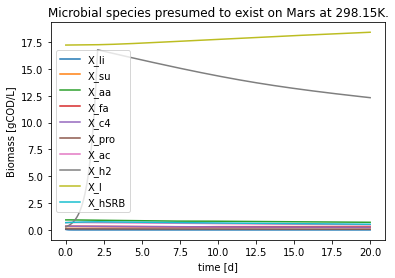

In [59]:
#some random plot function, which should be able to plot everything I need
def plot(instance, results t, flag_list):
    #possible: biomass, gasses, diluted, all
    try: t[0] == t[0]
    except: 
        print('No values generated to plot, first run dyn_sym(t_end).')
        return
    else:
        if(flag_list == 'biomass'):
            solu_index = range(17,27)
            
            
        plt.figure()
        plt.title(f'Microbial species presumed to exist on Mars at {instance.T_ad}K.')
        for i in results.keys()[solu_index]:    
            plt.plot(t, results.loc[:,i], label = i)
        plt.ylabel("Biomass [gCOD/L]")
        plt.xlabel("time [d]")
        plt.legend()


#cProfile.run('dyn_sim()')
mars = ADM1_instance(T_ad = 298.15, V_liq = 3400, V_gas = 300, p_atm = 1.013, q_ad = 0)
#mars.dyn_sim(20, file_name = 'testbed_values')
#solution, gasses, t = mars.dyn_sim(20.0, time_steps=2000) #generate results from simulation, [gCOD/L], [Bar], [days]
plot(mars, solution, gasses, t, 'biomass')

In [19]:
#analyse results from simulation
#air_pressure = 0.008 #bar
t_rover = [-1,0, 1, 8, 11, 13]
CH4_observations = [3, 5.78, 15.5, 2.13, 5, 5] #ppbv
Mars_atmosphere = [['Co2', 'N2', 'Ar', 'O2', 'CO', 'P'],[0.951, 0.0259, 0.0194, 0.0016, 0.008]]

plt.figure()
plt.title(f'Microbial species presumed to exist on Mars at {T_ad}K.')
for i in solution.keys()[14:27]:    
    plt.plot(t, solution.loc[:,i], label = i)
plt.ylabel("Biomass [gCOD/L]")
plt.xlabel("time [d]")
plt.legend()
#plt.savefig(f'ADM1_raw_biomass_{T_ad}.png')

P_gasses = ['P h2', 'P ch4', 'P H2S']
advanced_gasses = gasses[P_gasses]
advanced_gasses /= Mars_atmosphere[-1][-1] * 10e-9 #convert to ppbv 

plt.figure()
plt.title(f"Gas concentration at point source, T = {T_ad}K.")
for i in P_gasses:
    plt.plot(t[0:-1], advanced_gasses.loc[:,i], label = i)
    
plt.plot(t_rover, CH4_observations, 'o', label = 'CH4 data from curriosity rover')
plt.ylabel("Gas [ppbv]")
plt.xlabel("time [d]")
plt.legend()
#plt.savefig(f'ADM1_raw_gasses_{T_ad}.png')

NameError: name 'T_ad' is not defined

<Figure size 432x288 with 0 Axes>

In [18]:
def dilution(instance, data_simulation, data_observation):
    #simple dilution using a half sphere to compare the found concentration to the simulated concentration a distance away from the source
    v1 = instance.V_gas 
    c1 = data_simulation['P ch4'].max()
    c2 = max(data_observations) 
    r = ((3 * c1 * v1) /( 8* np.pi * c2))**(1/3)
    v2 = r**3 * 8/3 * np.pi
    new_data_simulation = data_simulation * (v1/v2)
    
    #time shift
    
    print(f'Roughly {r/1000:.2e} [km] from the source.')
    
    #plot the scaled data, visually the peaks seem to be shifted one day, therefor the Mars data is shifted one day forward
    time_shift = 7
    
    plt.figure()
    plt.title("Scaled and shifted simulation data to match CH4 peaks.")
    
    for i in P_gasses[1:]:
        plt.plot(t[0:-1], new_gasses.loc[:,i], label = f'{i}, {r:.2e} [m] from source')
        
    plt.plot(np.array(t_rover) + time_shift, CH4_observations, 'o', label = 'CH4 Data from curriosity rover shifted in time')
    plt.ylabel("Gas [ppbv]")
    plt.xlabel("time [d]")
    plt.legend()
    #plt.savefig(f'ADM1_edited_CH4_{T_ad}.png')

NameError: name 'V_gas' is not defined

In [ ]:

def loading_bar(i, max_range, bars = 10):
    a = max_range / bars
    if i % int(a) == 0:
        print('{', '|' * (int(i / a)+1) ,(' ' * int(((max_range - i)/a)-1)), '}')

#max_range = 10000000
#for i in range(max_range):
#    loading_bar(i, max_range)
#    
a = [1,2,3,5]
a = np.array(a) + 2
print(a)

range()